# Life history traits model 33

Taylor Chapter 3  
model to describe age-structured life history traits of understudied Carcharhinid species

Model versions: mixed effects, limited covariates.  same as 31 except with lmat added back in

### Set up notebook

In [6]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


AttributeError: module 'arviz' has no attribute 'geweke'

In [ ]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [ ]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

### Import and structure data

In [ ]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]

In [5]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [6]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(560, 37)

In [7]:
# take out potential problem stocks
out = ['GSH-I-17', 'SPD-I-19', 'MLK-I-17']
mdata = mdata[~mdata.Stock_Year.isin(out)]

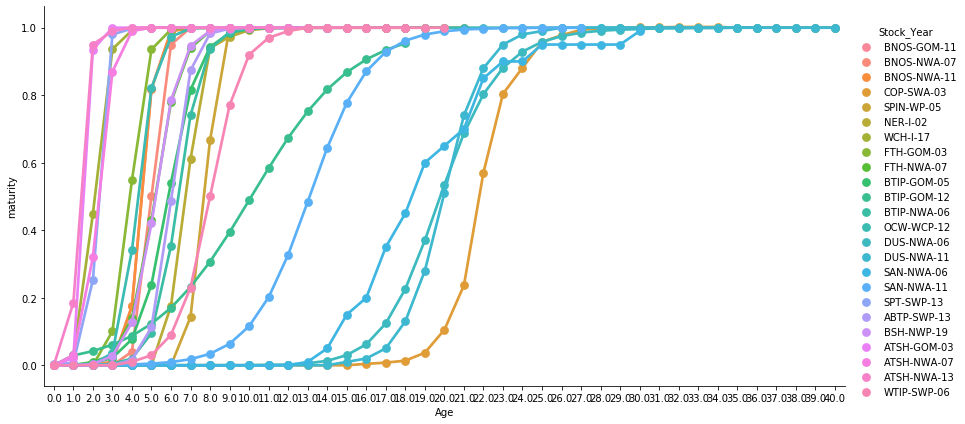

In [8]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [9]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [10]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'COP-SWA-03',
 'SPIN-WP-05',
 'NER-I-02',
 'WCH-I-17',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'OCW-WCP-12',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPT-SWP-13',
 'ABTP-SWP-13',
 'BSH-NWP-19',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'WTIP-SWP-06']

In [11]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
#ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
TEMP = mdata.temp_pref.values[Sind]

In [12]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
TEMP = stdise(TEMP)


# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Model Specification

In [19]:
# random effects model with all covariates
# only take out ones that have a data-quality or literature-based reason to be excluded.
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0.5, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K +  β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β11*LMAT + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH + B11*LMAT * B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [20]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Lmat-S, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, K-S, Depth-S, Lmax-S, S_, S_sigma, GS, Temperature, Lmat, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24290 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

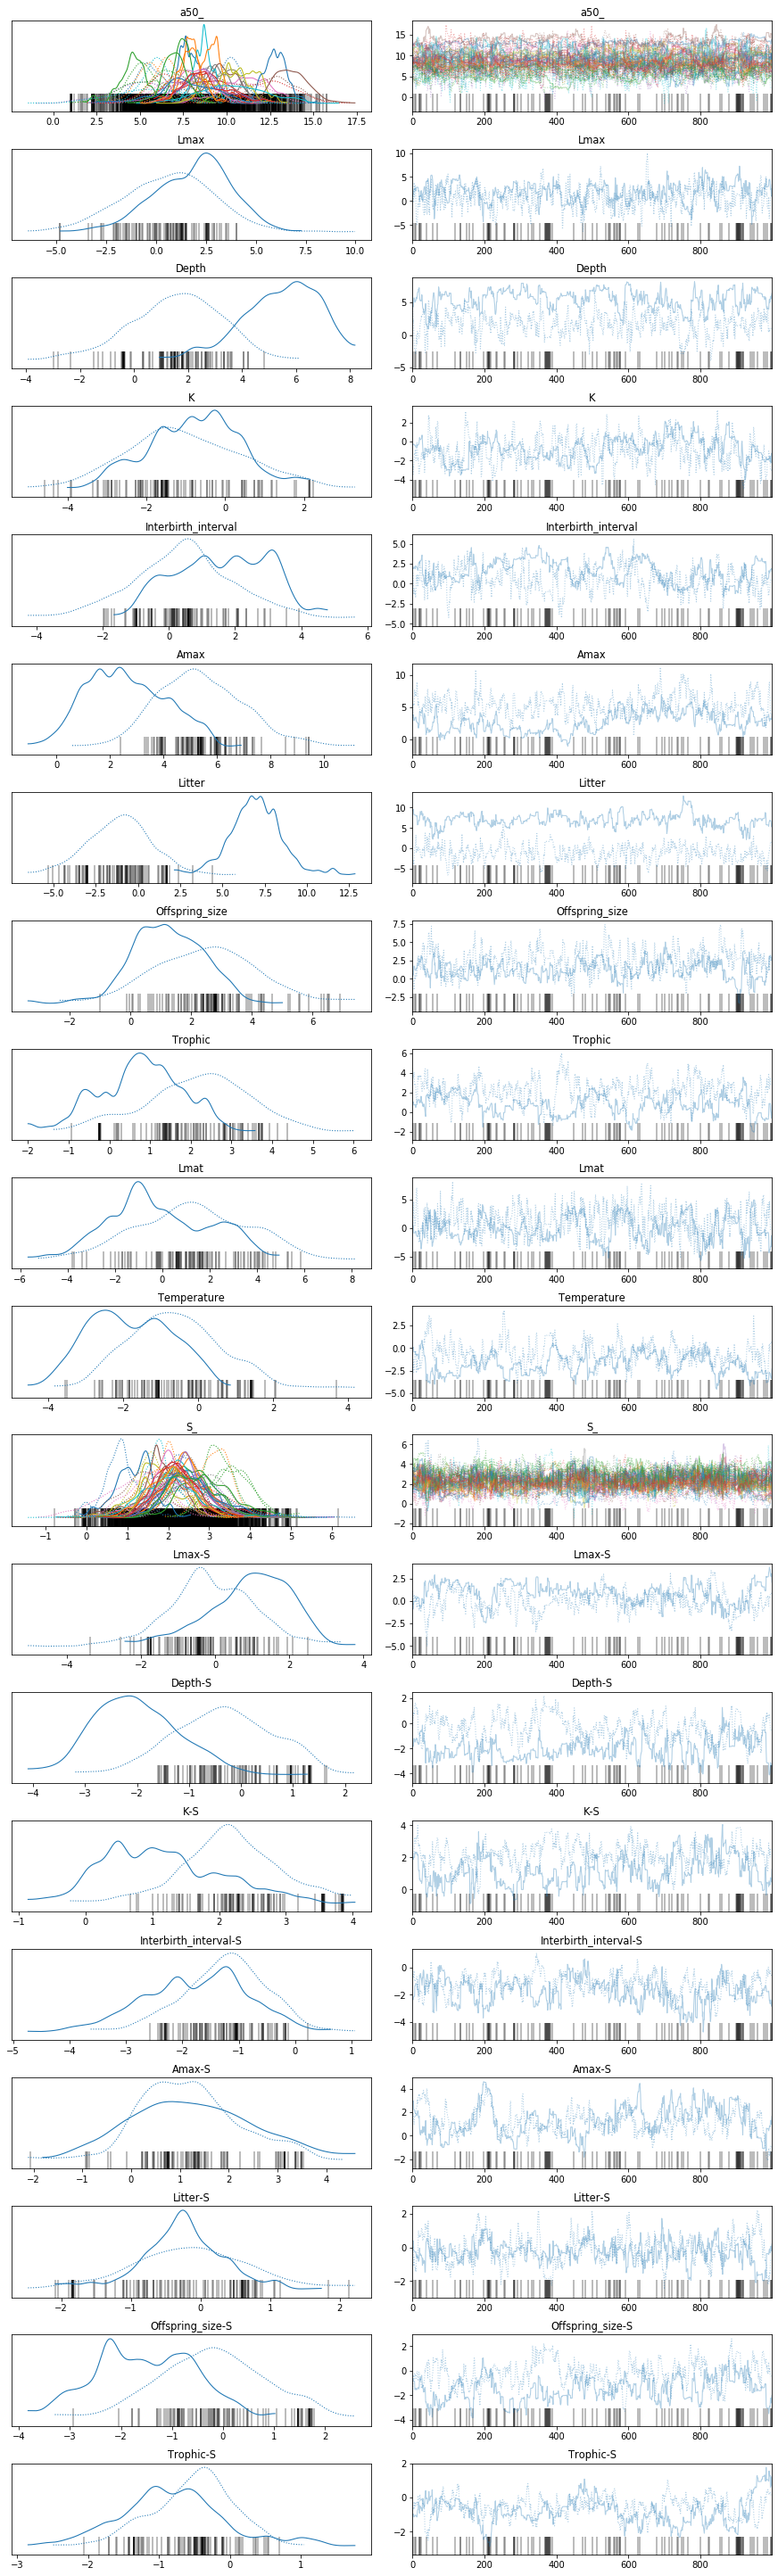

In [22]:
#check model performance
pm.traceplot(trace1);

In [23]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging
# value of 1.4 is too high

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50_[0]    6.714  1.374   4.165    8.776      0.789    0.624       3.0   
a50_[1]    6.860  1.429   4.422    9.202      0.826    0.656       3.0   
a50_[2]    6.364  1.421   3.728    8.503      0.826    0.659       3.0   
a50_[3]   10.694  2.224   6.904   14.606      1.187    0.921       4.0   
a50_[4]    6.277  2.059   2.505    9.860      0.980    0.772       4.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu_S[20]   6.124  1.149   3.704    8.089      0.418    0.307       8.0   
mu_S[21]   2.930  0.583   1.976    4.253      0.170    0.127      12.0   
mu_S[22]   4.056  0.620   2.689    4.806      0.250    0.186       6.0   
mu_S[23]   1.273  0.241   0.875    1.739      0.042    0.032      33.0   
S2         0.048  0.039   0.008    0.090      0.028    0.023       2.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50_[0]      3.0       4.0     103.0   1.65  
a50_[1]      3.0       3.0      93.0   1.69  
a50_[2]      3.0       3.0      98.0   1.69  
a50_[3]      4.0       4.0      59.0   1.54  
a50_[4]      4.0       4.0     107.0   1.43  
...          ...       ...       ...    ...  
mu_S[20]     8.0      10.0     156.0   1.24  
mu_S[21]    11.0      18.0      62.0   1.46  
mu_S[22]     6.0       8.0     268.0   1.35  
mu_S[23]    28.0     395.0      78.0   1.58  
S2           2.0       3.0      45.0   1.83  

[121 rows x 11 columns]

In [24]:
# random effects model with some covs removed
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
#    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
#    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
#    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
 #   B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
#    B8 = pm.Normal('Litter-S', 0, 3)
#   B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
#    B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP +  β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B7*AMAX  + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [25]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, Lmax-S, S_, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19118 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


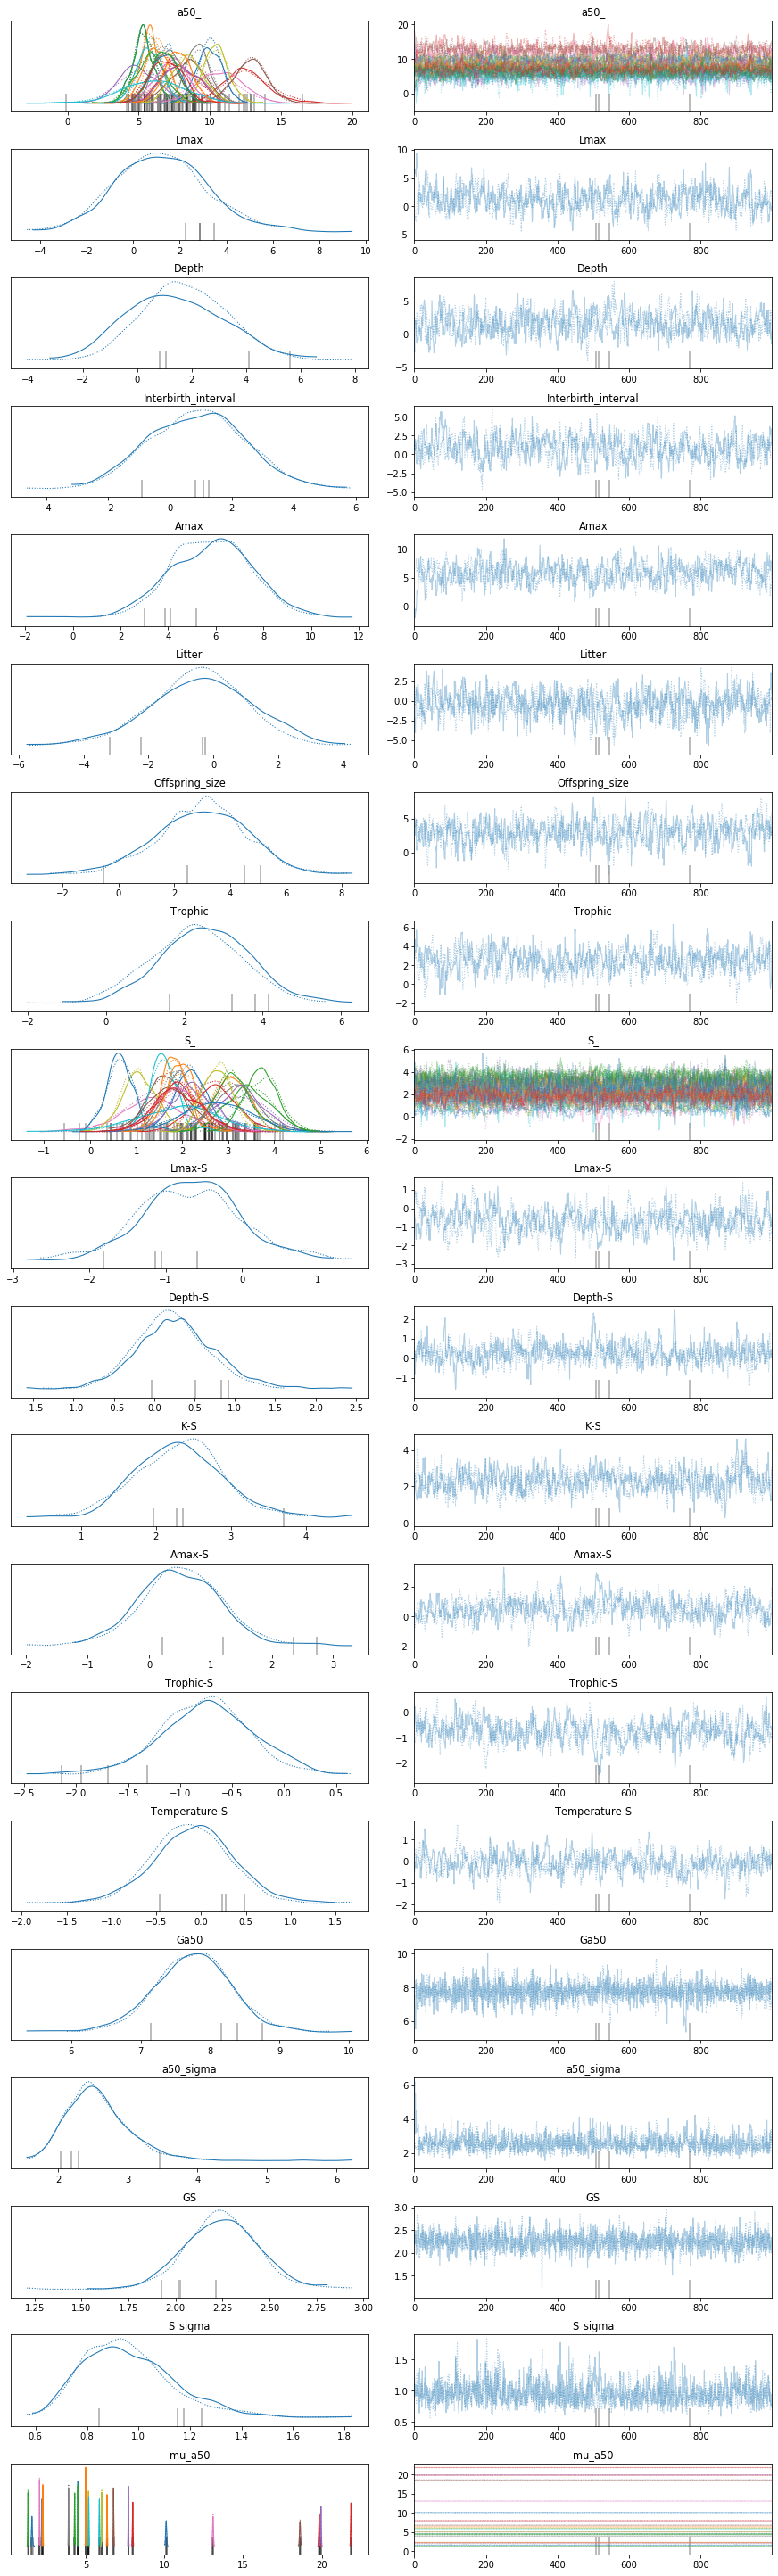

In [26]:
#check model performance
pm.traceplot(trace2);

In [27]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50_[0]    5.372  0.736   3.872    6.661      0.042    0.030     310.0   
a50_[1]    5.868  0.736   4.428    7.224      0.042    0.030     311.0   
a50_[2]    5.372  0.736   3.951    6.738      0.042    0.030     310.0   
a50_[3]   12.624  1.661   9.574   15.828      0.078    0.056     454.0   
a50_[4]    5.003  1.456   2.293    7.622      0.072    0.051     404.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu_S[20]   6.612  0.496   5.761    7.482      0.015    0.011    1081.0   
mu_S[21]   2.666  0.075   2.526    2.806      0.002    0.001    2125.0   
mu_S[22]   4.401  0.173   4.070    4.718      0.003    0.002    2551.0   
mu_S[23]   1.196  0.023   1.152    1.240      0.001    0.000    2012.0   
S2         0.008  0.000   0.008    0.009      0.000    0.000    1673.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50_[0]    308.0     312.0     574.0    1.0  
a50_[1]    309.0     312.0     571.0    1.0  
a50_[2]    308.0     311.0     569.0    1.0  
a50_[3]    443.0     467.0     573.0    1.0  
a50_[4]    404.0     405.0     678.0    1.0  
...          ...       ...       ...    ...  
mu_S[20]  1027.0    1424.0     974.0    1.0  
mu_S[21]  2125.0    2112.0    1391.0    1.0  
mu_S[22]  2482.0    2744.0    1033.0    1.0  
mu_S[23]  2008.0    2004.0    1525.0    1.0  
S2        1673.0    1672.0    1285.0    1.0  

[114 rows x 11 columns]

In [28]:
# Model 3 - run model without age params or VB params to see if you can predict shark status without this data
with pm.Model() as mat3:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0.5, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
#    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
#    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
 #   B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
 #   B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP +  β6*INTR + β8*LITT + β9*OFFSZ + β10*TROPH + β11*LMAT + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B6*INTR + B8*LITT + B9*OFFSZ + B10*TROPH + B11*LMAT * B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [29]:
# Sampling
# go back to 5000 for final run
with mat3:
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Lmat-S, Trophic-S, Offspring_size-S, Litter-S, Interbirth_interval-S, Depth-S, Lmax-S, S_, S_sigma, GS, Temperature, Lmat, Trophic, Offspring_size, Litter, Interbirth_interval, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26620 seconds.
The acceptance probability does not match the target. It is 0.8951095578698954, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


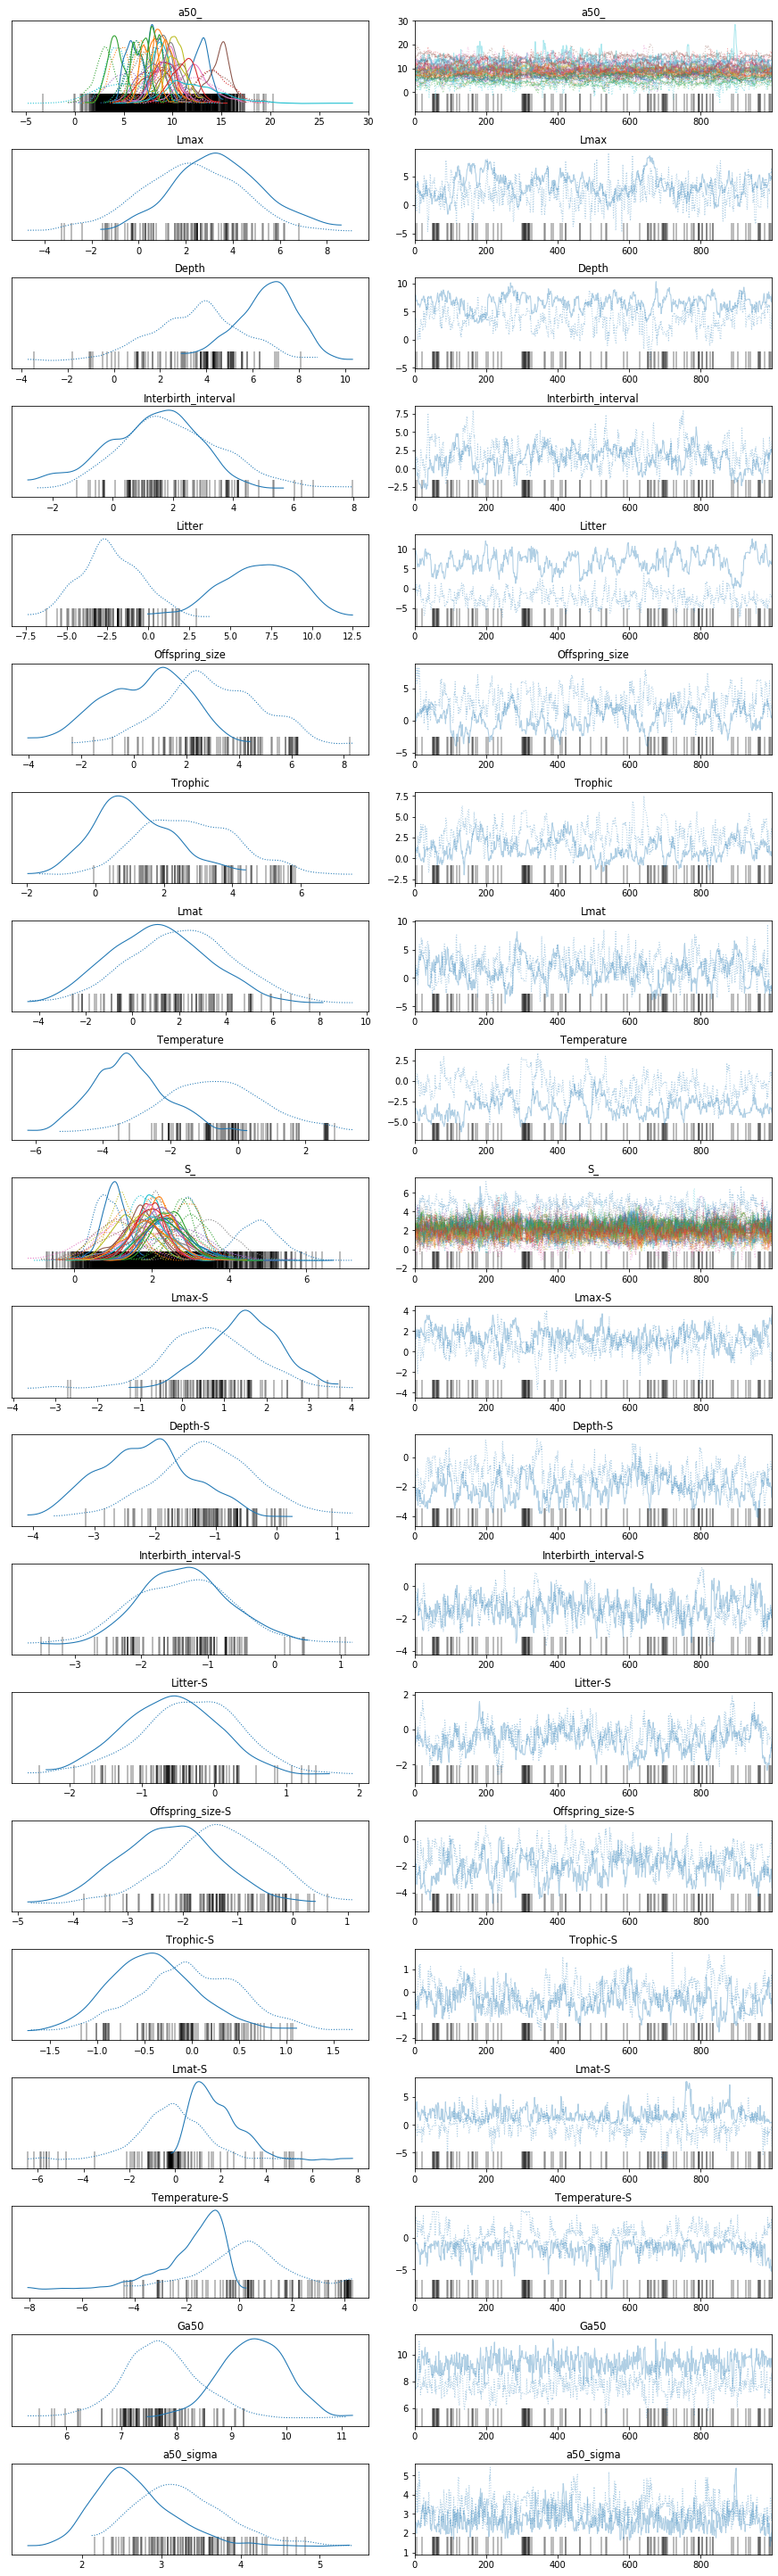

In [30]:
#check model performance
pm.traceplot(trace3);

In [31]:
pm.summary(trace3)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50_[0]    7.261  1.296   4.909    9.479      0.729    0.573       3.0   
a50_[1]    7.750  1.290   5.389    9.973      0.724    0.569       3.0   
a50_[2]    7.259  1.293   4.909    9.479      0.726    0.571       3.0   
a50_[3]   11.259  3.254   6.020   16.687      1.984    1.592       3.0   
a50_[4]    6.450  2.033   2.854   10.050      0.916    0.690       5.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu_S[20]   5.342  1.184   3.265    6.974      0.731    0.599       3.0   
mu_S[21]   3.070  0.701   2.169    4.519      0.285    0.212       6.0   
mu_S[22]   4.150  0.598   2.842    4.997      0.204    0.149       9.0   
mu_S[23]   1.255  0.197   0.936    1.725      0.035    0.029      32.0   
S2         0.047  0.039   0.008    0.090      0.027    0.023       2.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50_[0]      3.0       3.0      79.0   1.67  
a50_[1]      3.0       3.0      74.0   1.66  
a50_[2]      3.0       3.0      77.0   1.67  
a50_[3]      3.0       3.0     111.0   1.73  
a50_[4]      5.0       5.0     160.0   1.35  
...          ...       ...       ...    ...  
mu_S[20]     3.0       3.0     175.0   1.73  
mu_S[21]     6.0       8.0     130.0   1.54  
mu_S[22]     9.0      12.0     432.0   1.26  
mu_S[23]    24.0     436.0      66.0   1.51  
S2           2.0       3.0     160.0   1.83  

[117 rows x 11 columns]

In [ ]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)

In [ ]:
pm.save_trace(trace2)

### Model Results

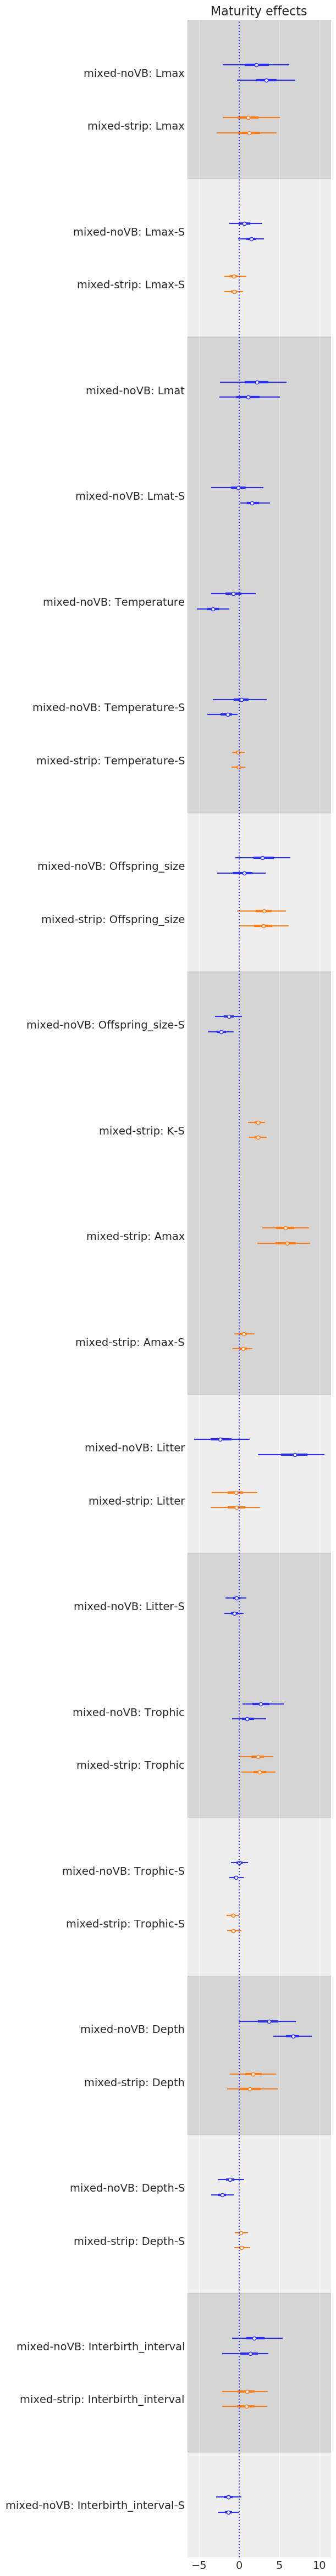

<Figure size 720x480 with 0 Axes>

In [35]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest([trace3, trace2], 
                      model_names=["mixed-noVB", "mixed-strip"], var_names=["Lmax", "Lmax-S", "Lmat", "Lmat-S", "Temperature", "Temperature-S", "Offspring_size", "Offspring_size-S", "K-S", "Amax", "Amax-S", "Litter", "Litter-S",  "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval", "Interbirth_interval-S"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat32&31_forest.jpg');

### Model Comparison

In [36]:
#WAIC for model 30
pm.waic(trace1, scale='deviance')

Computed from 2000 by 516 log-likelihood matrix

              Estimate       SE
deviance_waic  1792.60   924.76
p_waic         2490.64        -

There has been a warning during the calculation. Please check the results.

In [37]:
#WAIC for model 31
pm.waic(trace2, scale='deviance')

Computed from 2000 by 516 log-likelihood matrix

              Estimate       SE
deviance_waic -3364.42   129.77
p_waic           96.15        -

There has been a warning during the calculation. Please check the results.

In [38]:
#WAIC for model 32
pm.waic(trace3, scale='deviance')

Computed from 2000 by 516 log-likelihood matrix

              Estimate       SE
deviance_waic  1902.86   996.28
p_waic         2546.09        -

There has been a warning during the calculation. Please check the results.

Model 2 slightly better than model 1


#### Look for 'bad' datapoints

In [39]:
loo1 = pm.loo(trace1, mat1)
loo1

Computed from 2000 by 516 log-likelihood matrix

         Estimate       SE
elpd_loo   598.92    90.14
p_loo      995.42        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      445   86.2%
 (0.5, 0.7]   (ok)         29    5.6%
   (0.7, 1]   (bad)        28    5.4%
   (1, Inf)   (very bad)   14    2.7%

In [40]:
loo2 = pm.loo(trace2, mat2)
loo2

Computed from 2000 by 516 log-likelihood matrix

         Estimate       SE
elpd_loo  1673.48    64.97
p_loo      104.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      469   90.9%
 (0.5, 0.7]   (ok)         15    2.9%
   (0.7, 1]   (bad)        19    3.7%
   (1, Inf)   (very bad)   13    2.5%

In [41]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]

In [42]:
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [44]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# Edit column names
# Skip this step - seems unecessary & causes glitches
#colnames = np.array(list(result1.columns), dtype=object)

#colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

#result1.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat30_model_results.csv')
result1.head()

a50___0   a50___1   a50___2   a50___3   a50___4   a50___5    a50___6  \
0  8.243296  8.374930  8.116924  9.511446  6.556218  8.177111  11.341372   
1  8.243788  8.374087  8.115808  9.510052  6.556432  8.176891  11.338742   
2  8.231789  8.385303  8.142958  9.546999  6.519300  8.164769  11.358510   
3  8.226324  8.372893  8.094238  9.374956  6.609803  8.306082  11.207885   
4  8.223837  8.895727  8.139621  9.354376  6.962049  9.460234  11.008065   

     a50___7    a50___8   a50___9  ...  mu_S__15  mu_S__16  mu_S__17  \
0  10.494975  11.921291  8.749138  ...  0.442500  0.683843  5.617747   
1  10.494615  11.920322  8.749913  ...  0.442203  0.684630  5.616867   
2  10.519734  11.920489  8.760125  ...  0.410945  0.659214  5.678001   
3  10.649254  11.888532  8.768275  ...  0.627597  0.837328  5.498104   
4  10.514849  11.475069  8.424575  ...  0.541638  0.815450  6.022898   

   mu_S__18  mu_S__19  mu_S__20  mu_S__21  mu_S__22  mu_S__23        S2  
0  2.162273 -0.018753  6.795259  4.777588  3.322872  1.109991  0.087643  
1  2.162569 -0.017648  6.795598  4.778192  3.323618  1.107760  0.087638  
2  2.240855 -0.018682  6.878329  4.802208  3.411430  1.113210  0.087650  
3  2.087068 -0.010666  6.796050  4.628293  3.255473  1.129611  0.087203  
4  3.163049 -0.019703  7.772085  4.239265  3.700238  1.296497  0.080197  

[5 rows x 121 columns]

In [45]:
# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat31_model_results.csv')

In [46]:
result1.columns[5:100]

Index(['a50___5', 'a50___6', 'a50___7', 'a50___8', 'a50___9', 'a50___10',
       'a50___11', 'a50___12', 'a50___13', 'a50___14', 'a50___15', 'a50___16',
       'a50___17', 'a50___18', 'a50___19', 'a50___20', 'a50___21', 'a50___22',
       'a50___23', 'Lmax', 'Depth', 'K', 'Interbirth_interval', 'Amax',
       'Litter', 'Offspring_size', 'Trophic', 'Lmat', 'Temperature', 'S___0',
       'S___1', 'S___2', 'S___3', 'S___4', 'S___5', 'S___6', 'S___7', 'S___8',
       'S___9', 'S___10', 'S___11', 'S___12', 'S___13', 'S___14', 'S___15',
       'S___16', 'S___17', 'S___18', 'S___19', 'S___20', 'S___21', 'S___22',
       'S___23', 'Lmax-S', 'Depth-S', 'K-S', 'Interbirth_interval-S', 'Amax-S',
       'Litter-S', 'Offspring_size-S', 'Trophic-S', 'Lmat-S', 'Temperature-S',
       'Ga50', 'a50_sigma', 'GS', 'S_sigma', 'mu_a50__0', 'mu_a50__1',
       'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5', 'mu_a50__6',
       'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10', 'mu_a50__11',
       'mu

In [47]:
# Grab data from mat1 results (model 30)
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s (no effect of covariates)
a50s = np.array([np.median(result1[x]) for x in np.array(['a50___'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S___'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [ ]:
result2.columns

In [48]:
#Grab data from mat2 (model 31 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

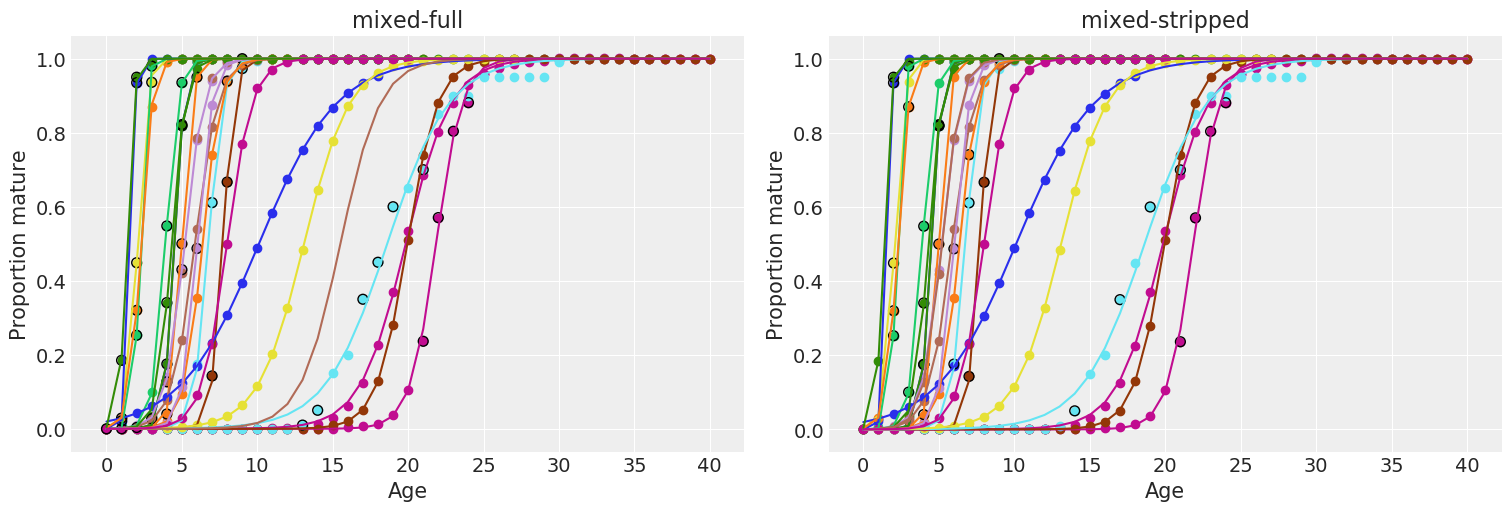

In [50]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
ax_ = axes.flatten()

#Plot mat16
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-full')

#Plot mat17
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('mixed-stripped')

#save results
plt.savefig('mat30_mat31_modelfit.jpg',dpi=300);

In [ ]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
# plot bad datapoints
plt.scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)